In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules.transformer as transformer
import numpy as np
from tqdm import tqdm
import random

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
# else if mps is available
elif torch.backends.mps.is_available():
    device = "mps"

In [2]:
import torch
import random
from tqdm import tqdm


# Helper function to process each line
def process_line(line):
    x, y = line.strip().split()
    x = torch.tensor([["s", "(", ")", "e", "p"].index(c) for c in x])
    y = torch.tensor(int(y))
    return x, y


# Load data function
def load_data(file_path):
    data = []
    with open(file_path, "r") as f:
        for line in tqdm(f):
            data.append(process_line(line))
    random.shuffle(data)
    return data


# Load and shuffle training and test data
train_data = load_data("balanced_parens_data/train_dataset.txt")
test_data = load_data("balanced_parens_data/test_dataset.txt")


# Create tensors for all training and test data
def create_tensors(data):
    x = [item[0] for item in data]
    y = [item[1] for item in data]
    return torch.stack(x), torch.tensor(y)


train_x, train_y = create_tensors(train_data)
test_x, test_y = create_tensors(test_data)

261376it [00:03, 73671.10it/s]
65344it [00:00, 71141.07it/s]


In [3]:
seq_len = train_x.size(1)
non_pad = 4


# Define the model
class TransformerClassifier(nn.Module):
    def __init__(
        self, seq_len=seq_len, non_pad=non_pad, dim_feedforward=2, num_heads=1
    ):
        super(TransformerClassifier, self).__init__()
        self.seq_len = seq_len
        self.non_pad = non_pad
        self.dim_feedforward = dim_feedforward
        self.self_attn = nn.MultiheadAttention(
            non_pad + seq_len, num_heads, dropout=0.1
        )
        self.layernorm = nn.LayerNorm(non_pad + seq_len)
        self.linear = nn.Linear(non_pad + seq_len, dim_feedforward)
        self.final_fc = nn.Linear(seq_len * dim_feedforward, 1, bias=False)
        self.final_bias = nn.Parameter(torch.zeros(1))
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, print_extras=False):
        device = x.device
        N = x.size(0)  # Batch size

        # Embeddings: replace each index with a one-hot vector
        one_hot_x = F.one_hot(x, num_classes=5).float().to(device)  # (N, seq_len, 5)
        embeddings = one_hot_x[
            :, :, :-1
        ]  # (N, seq_len, non_pad) - removing the last column

        # Positional encodings: use a one-hot-based positional encoding
        pos_enc = torch.eye(self.seq_len).to(device)  # (seq_len, seq_len)
        pos_enc = pos_enc.unsqueeze(0).repeat(N, 1, 1)  # (N, seq_len, seq_len)

        # Create key_padding_mask and adjust positional encodings
        key_padding_mask = torch.all(embeddings == 0, dim=-1)  # (N, seq_len)
        pos_enc = pos_enc.masked_fill(key_padding_mask.unsqueeze(-1), 0)

        # Concatenate embeddings and positional encodings
        concatenated = torch.cat(
            (embeddings, pos_enc), dim=-1
        )  # (N, seq_len, non_pad + seq_len)

        # Attention mask to not attend to any padding tokens
        attention_mask = key_padding_mask.unsqueeze(1).repeat(
            1, self.seq_len, 1
        )  # (N, seq_len, seq_len)

        # Encoder processing
        concatenated = concatenated.transpose(0, 1)  # (seq_len, N, non_pad + seq_len)
        self_attn, scores = self.self_attn(
            concatenated,
            concatenated,
            concatenated,
            key_padding_mask=key_padding_mask,
            attn_mask=attention_mask,
        )
        attended_embeds = concatenated + self_attn

        # attn is (seq_len, N, d_model) - we want (N, seq_len, d_model) for layer norm
        attended_embeds = attended_embeds.transpose(
            0, 1
        )  # (N, seq_len, non_pad + seq_len)
        normed = self.layernorm(attended_embeds)
        normed = self.dropout(normed)
        encoded_output = F.relu(self.linear(normed))

        # Zero out padding embeddings and flatten
        masked_output = encoded_output.masked_fill(key_padding_mask.unsqueeze(-1), 0)
        flattened_output = masked_output.view(
            masked_output.size(0), -1
        )  # (N, seq_len * dim_feedforward)

        # Final fully connected layer
        final_output = self.final_fc(flattened_output)

        # Scale by the number of non-padding tokens
        non_padding_tokens = self.seq_len - key_padding_mask.sum(dim=-1, keepdim=True)
        scaled_output = final_output / non_padding_tokens + self.final_bias

        # Apply sigmoid activation
        output = self.sigmoid(scaled_output)

        if not print_extras:
            return output

        return {
            "output": output,
            "scores": scores,
            "masked_output": masked_output,
            "final_fc_weight": self.final_fc.weight.data,
            "final_fc_bias": self.final_bias,
            "encoded_fc_weight": self.linear.weight.data,
            "encoded_fc_bias": self.linear.bias.data,
            "normed": normed,
        }

In [4]:
from tqdm import tqdm
from torch import mps
import gc

gc.collect()
mps.empty_cache()
train_x, train_y, test_x, test_y = (
    train_x.to(device),
    train_y.to(device),
    test_x.to(device),
    test_y.to(device),
)

# Train the model
model = TransformerClassifier().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(2000):
    # Choose a subset of size 1000
    indices = torch.randperm(len(train_x))[:100]
    train_x_subset = train_x[indices]
    train_y_subset = train_y[indices]

    model.train()
    optimizer.zero_grad()
    output = model(train_x_subset)
    loss = criterion(output, train_y_subset.float().view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    # If epoch is a multiple of 10, evaluate the model on the test data
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            # Pick random 100 samples from the test data
            indices = torch.randperm(len(test_x))[:200]
            test_x_subset = test_x[indices]
            test_y_subset = test_y[indices]
            output = model(test_x_subset)
            # Calculate the accuracy
            correct = (output > 0.5).squeeze(1).float() == test_y_subset.float()
            accuracy = correct.sum() / len(correct)
            print(f"Accuracy: {accuracy.item()}")
            # If accuracy goes above .97, set learning rate to 0.0001
            if accuracy > 0.97:
                optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 10, Loss: 0.6928108930587769
Accuracy: 0.4699999988079071
Epoch 20, Loss: 0.6921007633209229
Accuracy: 0.44999998807907104
Epoch 30, Loss: 0.6933837532997131
Accuracy: 0.5400000214576721
Epoch 40, Loss: 0.6929507851600647
Accuracy: 0.574999988079071
Epoch 50, Loss: 0.692545473575592
Accuracy: 0.5249999761581421
Epoch 60, Loss: 0.6925168633460999
Accuracy: 0.574999988079071
Epoch 70, Loss: 0.691568911075592
Accuracy: 0.5450000166893005
Epoch 80, Loss: 0.6924455761909485
Accuracy: 0.5199999809265137
Epoch 90, Loss: 0.692400336265564
Accuracy: 0.6650000214576721
Epoch 100, Loss: 0.6926457285881042
Accuracy: 0.6449999809265137
Epoch 110, Loss: 0.6904574632644653
Accuracy: 0.6549999713897705
Epoch 120, Loss: 0.6882387399673462
Accuracy: 0.6650000214576721
Epoch 130, Loss: 0.6886247992515564
Accuracy: 0.7099999785423279
Epoch 140, Loss: 0.6831310987472534
Accuracy: 0.6850000023841858
Epoch 150, Loss: 0.6749887466430664
Accuracy: 0.6050000190734863
Epoch 160, Loss: 0.6756802797317505
Ac

In [5]:
model.eval()
with torch.no_grad():
    correct = 0
    batch_size = 200
    for i in tqdm(range(0, len(test_x), batch_size)):
        batch_end = min(i + batch_size, len(test_x))
        output = model(test_x[i:batch_end].to("mps"))
        y = test_y[i:batch_end].to("mps")
        predictions = (output > 0.5).squeeze().float()

        # Ensure predictions and y have the same shape
        if predictions.shape != y.shape:
            predictions = predictions.view_as(y)

        correct += (predictions == y.float()).sum().item()
    accuracy = correct / len(test_x)

print(f"Test accuracy: {accuracy}")

100%|██████████| 327/327 [00:01<00:00, 272.88it/s]

Test accuracy: 0.902393486777669


In [6]:
# Save the model
torch.save(model.state_dict(), "balanced_parens_model.pth")

In [7]:
def make_string_prettier(s):
    def replace_long_blocks(char, s):
        count = 0
        result = []
        for c in s:
            if c == char:
                count += 1
            else:
                if count > 10:
                    result.append(f"[{count} {char}]")
                else:
                    result.extend([char] * count)
                result.append(c)
                count = 0
        if count > 10:
            result.append(f"[{count} {char}]")
        else:
            result.extend([char] * count)
        return "".join(result)

    s = replace_long_blocks("p", s)
    s = replace_long_blocks("a", s)
    s = replace_long_blocks("b", s)
    return s

In [8]:
# Load model
model = TransformerClassifier()
model.load_state_dict(torch.load("balanced_parens_model.pth"))

# Pick a random sample from the test data
random_index = random.randint(0, len(train_x))
print(random_index)
x = train_x[random_index]
y = train_y[random_index]
# Map x back to the original characters
original_str = "".join(["s()ep"[i] for i in x])
s_index = original_str.index("s")
e_index = original_str.index("e")
print(f"S is at index {s_index} and E is at index {e_index}")
original_str = make_string_prettier(original_str)
print(f"Original string: {original_str}")
print(f"True label: {y.item()}")

# Run it through the model
model.eval()
with torch.no_grad():
    output_dict = model(x.unsqueeze(0), True)
    for key, value in output_dict.items():
        if isinstance(value, torch.Tensor):
            output_dict[key] = value.squeeze().cpu().numpy()
    output = output_dict["output"]
    scores = output_dict["scores"]
    masked_output = output_dict["masked_output"]
    final_fc_weight = output_dict["final_fc_weight"]
    final_fc_bias = output_dict["final_fc_bias"]
    encoded_fc_weight = output_dict["encoded_fc_weight"]
    encoded_fc_bias = output_dict["encoded_fc_bias"]
    normed = output_dict["normed"]

print(f"Predicted label: {output.item()}")
# Plot scores as a heatmap
import matplotlib.pyplot as plt

# Need to determine why, when predicting 0, normed @ encoded_fc_weight.T is (_, 0) for everything
# Plot col 70 of normed and row 2 of encoded_fc_weight
desired_index = np.random.randint(0, seq_len)
plt.figure(figsize=(12, 4))
plt.plot(normed[desired_index, :])
plt.plot(encoded_fc_weight[1, :])
plt.plot(normed[desired_index, :] * encoded_fc_weight[1, :])
print(np.sum(normed[desired_index, :] * encoded_fc_weight[1, :]))
plt.title("Normed and encoded_fc_weight")
plt.xlabel("Position")
plt.ylabel("Value")
plt.legend(["Normed", "Encoded FC Weight", "Normed * Encoded FC Weight"])
plt.show()

scores = scores
# Trim scores to be from s_index to e_index
scores = scores[s_index : e_index + 1, s_index : e_index + 1]
plt.figure(figsize=(6, 6))
plt.imshow(scores, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Attention scores")
plt.xlabel("Query")
plt.ylabel("Key")
plt.show()

# Print masked_output as a heatmap that's 2 rows and 300 columns
masked_output = masked_output.T
orig_masked_output = masked_output
masked_output = masked_output[:, s_index : e_index + 1]
plt.figure(figsize=(12, 4))  # Adjust the width and height
plt.imshow(masked_output, cmap="hot", interpolation="nearest", aspect="auto")
plt.colorbar()
plt.title("Masked output")
plt.xlabel("Position")
plt.ylabel("Embedding dimension")
plt.show()

# Compute last layer values before final sum
last_weights = final_fc_weight.reshape(seq_len, -1)
final_nums = orig_masked_output.T * last_weights
# final_nums = np.sum(final_nums, axis=1)
# Print line graph of final_nums
plt.figure(figsize=(12, 4))
plt.plot(final_nums[:, 0])
plt.plot(final_nums[:, 1])
plt.title("Final numbers before sum")
plt.xlabel("Position")
plt.ylabel("Value")
plt.legend(["First dimension", "Second dimension"])
plt.show()

179442
S is at index 29 and E is at index 46
Original string: [29 p]s(())((()))())()(eppp
True label: 0


RuntimeError: Placeholder storage has not been allocated on MPS device!

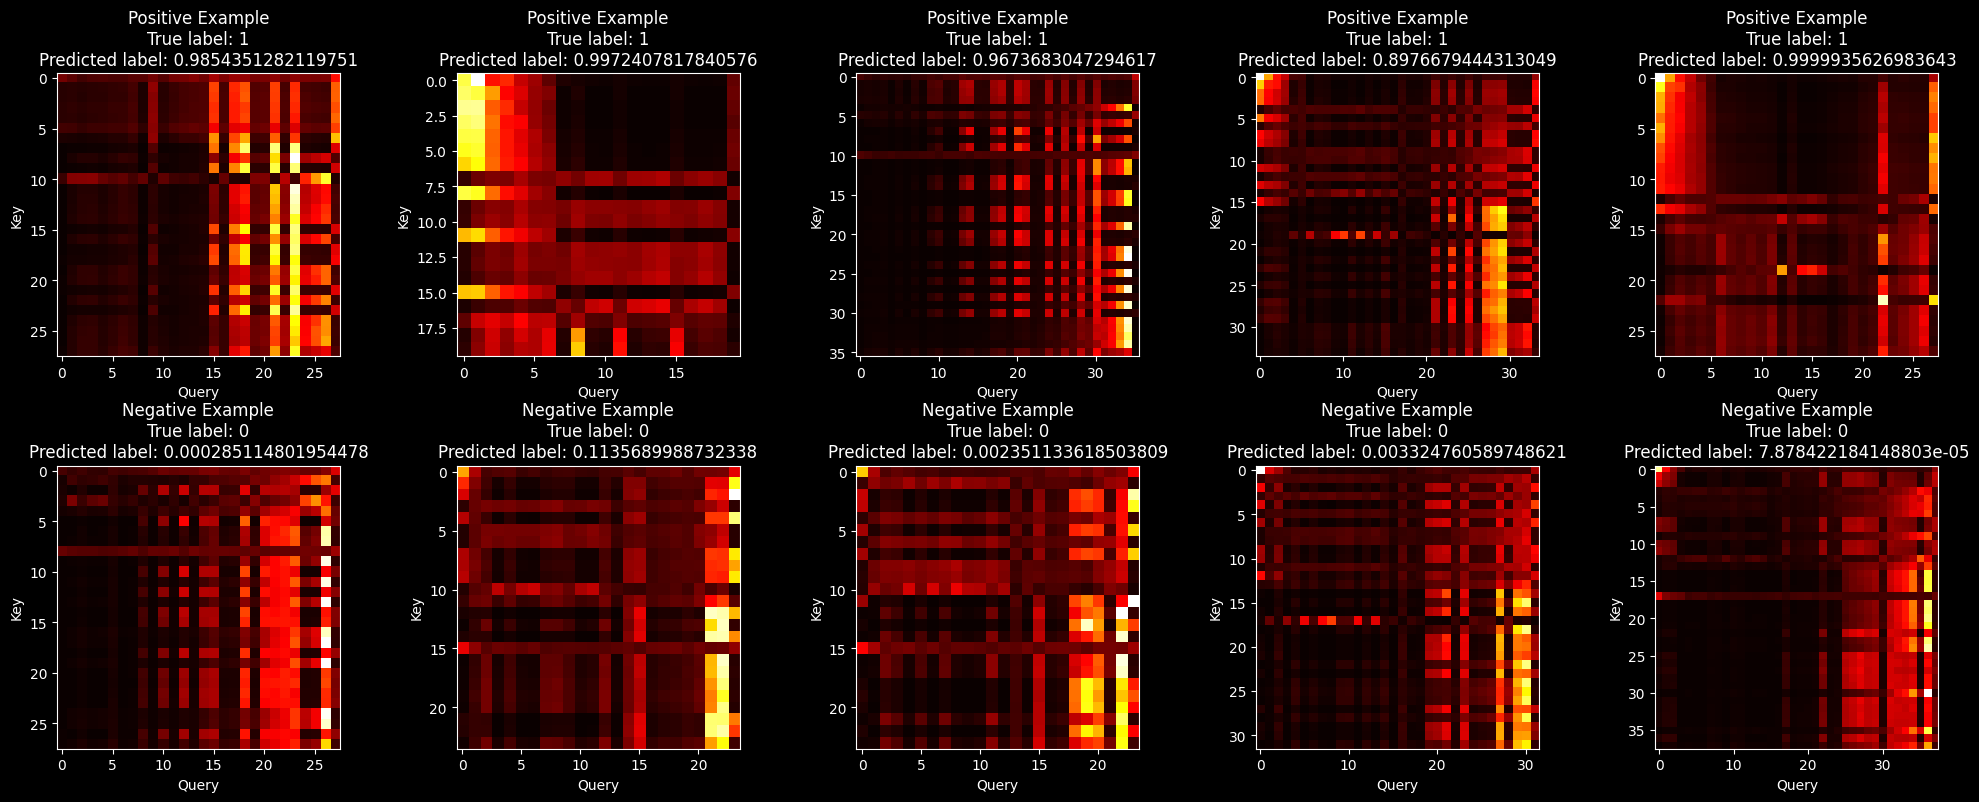

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

# Load model
model = TransformerClassifier()
model.load_state_dict(torch.load("balanced_parens_model.pth"))
model.to("cpu")


# Function to plot attention scores
def plot_attention_scores(ax, scores, title):
    ax.imshow(scores, cmap="hot", interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Query")
    ax.set_ylabel("Key")


# Identify positive and negative examples
positive_indices = []
negative_indices = []
for i in range(len(train_y)):
    if train_y[i] > 0.97:
        positive_indices.append(i)
    elif train_y[i] < 0.03:
        negative_indices.append(i)
    if len(positive_indices) >= 5 and len(negative_indices) >= 5:
        break
# Randomly sample 5 positive and 5 negative examples
positive_samples = positive_indices[:5]
negative_samples = negative_indices[:5]

# Create a 2x5 grid for plotting
fig, axs = plt.subplots(2, 5, figsize=(20, 8))


# Function to process and plot a single example
def process_and_plot_example(index, ax, label_type):
    x = train_x[index].to("cpu")
    y = train_y[index]

    # Map x back to the original characters
    original_str = "".join(["s()ep"[i] for i in x])
    s_index = original_str.index("s")
    e_index = original_str.index("e")

    # Run it through the model
    model.eval()
    with torch.no_grad():
        output_dict = model(x.unsqueeze(0), True)
        scores = output_dict["scores"].squeeze().cpu().numpy()

    # Trim scores to be from s_index to e_index
    scores = scores[s_index : e_index + 1, s_index : e_index + 1]

    # Plot attention scores
    plot_attention_scores(
        ax,
        scores,
        f"{label_type} Example\nTrue label: {y.item()}\nPredicted label: {output_dict['output'].item()}",
    )


# Process and plot positive examples
for i, index in enumerate(positive_samples):
    process_and_plot_example(index, axs[0, i], "Positive")

# Process and plot negative examples
for i, index in enumerate(negative_samples):
    process_and_plot_example(index, axs[1, i], "Negative")

plt.tight_layout()
plt.show()